Fix the seeds

In [1]:
import numpy as np
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [2]:
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

# Creating Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel measurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  False 



Here are the functions, which create measurements vectror for all patterns in Hadamard basis

In [3]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten().float()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten().float()).to(device)
    M = (Mplus - Mminus)

    return M

In [4]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Dataset with single-pixel measurements and target images (to option for creating dataset "full" - all MNIST images, "short-cut" - only 640 of "0" and 640 of "1")

In [5]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MeasurementsDataset(Dataset):
    def __init__(self, mnist, option):
        super().__init__()

        if option == "short-cut":
            if mnist.train:
                num = 640
            else:
                num = 128

        self.labels = mnist.targets
        if option == "short-cut":
            images = torch.cat([mnist.data[mnist.targets == 0][:num], mnist.data[mnist.targets == 1][:num]])
        elif option == "full":
            images = mnist.data
        
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                        transforms.Resize((px, px))])

        images = transform(images)
        self.target_images = (images - images.min()) / (images.max() - images.min())

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.target_images[indx]

    def __len__(self):
        return len(self.measurements)

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

option = "short-cut"

train_set = MeasurementsDataset(MNIST(root='./data', train=True, download=True), option=option)
test_set = MeasurementsDataset(MNIST(root='./data', train=False, download=True), option=option)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [7]:
variance = np.array([])
for i in range(px ** 2):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

# Training

Class for drawing plots

In [8]:
from collections import defaultdict
import matplotlib.pyplot as plt

class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="best")
        if history_len < 20:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(24 // n_groups, 5))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Training staff

In [9]:
def train(model, criterion, optimizer, i_arr, train_loader, test_loader,
          num_epochs=10, pp=None):

    if pp is None:
        pp = ProgressPlotter(groups=['loss'])

    for epoch in range(num_epochs):
        
        train_loss = 0
        model.train()
        for batch in train_loader:
            measurements, target_imgs = batch
            measurements, target_imgs = measurements.to(device), target_imgs.to(device)

            optimizer.zero_grad()

            x = measurements[:,i_arr]

            pred = model(x).to(device)
            pred = pred.view(-1, px, px).to(torch.float32)

            loss = criterion(pred, target_imgs)
            loss.backward()
            optimizer.step()
            
            l = loss.item()
            train_loss += l

        train_loss /= len(train_loader)

        val_loss = 0
        model.eval()
        for batch in test_loader:
            measurements, target_imgs = batch
            measurements, target_imgs = measurements.to(device), target_imgs.to(device)

            x = measurements[:, i_arr]

            pred = model(x).to(device)
            pred = pred.view(-1, px, px).to(torch.float32)

            loss = criterion(pred, target_imgs)

            l = loss.item()
            val_loss += l

        val_loss /= len(test_loader)

        pp.add_scalar('loss', train_loss, 'train')
        pp.add_scalar('loss', val_loss, 'test')
        pp.display()

    return pp

Model

In [10]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_length):
        super().__init__()
        self.len = input_length
        self.fc1 = nn.Linear(self.len, 1000)
        self.fc2 = nn.Linear(1000, 2000)
        self.fc3 = nn.Linear(2000, 4000)
        self.fc4 = nn.Linear(4000, 2000)
        self.fc5 = nn.Linear(2000, 1024)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, self.len)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        return x

Training with differet input layer size (number of measurements): 1024, 800, 500, 200, 100, 64, 40, 20, 10, 5, 1

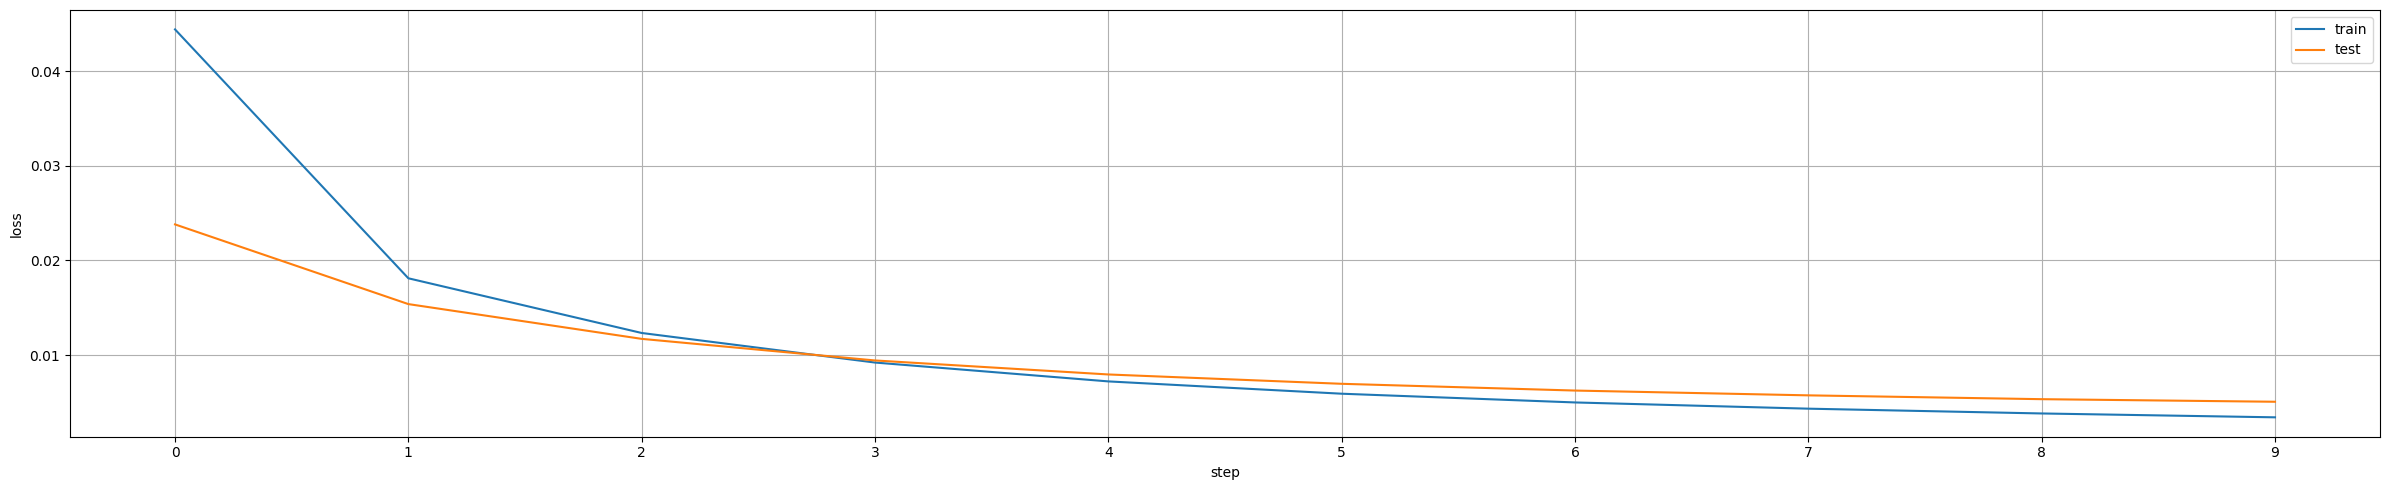

CPU times: total: 4min 12s
Wall time: 18.9 s


In [11]:
%%time

most_important_1024 = np.argsort(variance)[-1024:]

model_1024 = Net(1024).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1024.parameters(), lr=0.0001)

pp1024 = train(model_1024, criterion, optimizer, most_important_1024, train_loader, test_loader)

In [12]:
loss_1024 = pp1024.history_dict["loss"]["test"][-1]
print(f"Loss 1024: {loss_1024}")

Loss 1024: 0.005075582070276141


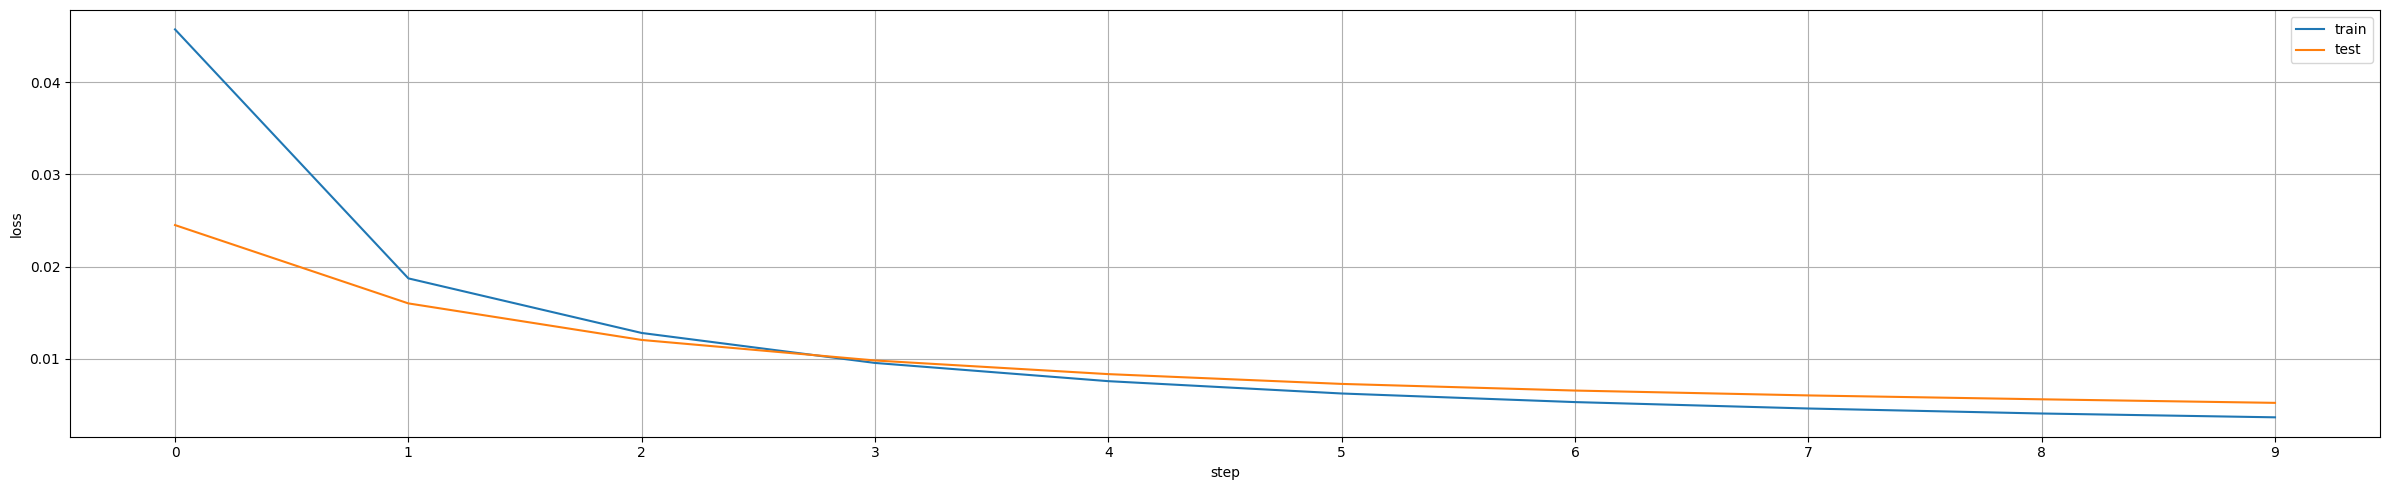

CPU times: total: 4min 10s
Wall time: 18.2 s


In [13]:
%%time

most_important = np.argsort(variance)[-800:]

model = Net(800).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp800 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [14]:
loss_800 = pp800.history_dict["loss"]["test"][-1]
print(f"Loss 800: {loss_800}")

Loss 800: 0.005188574607018381


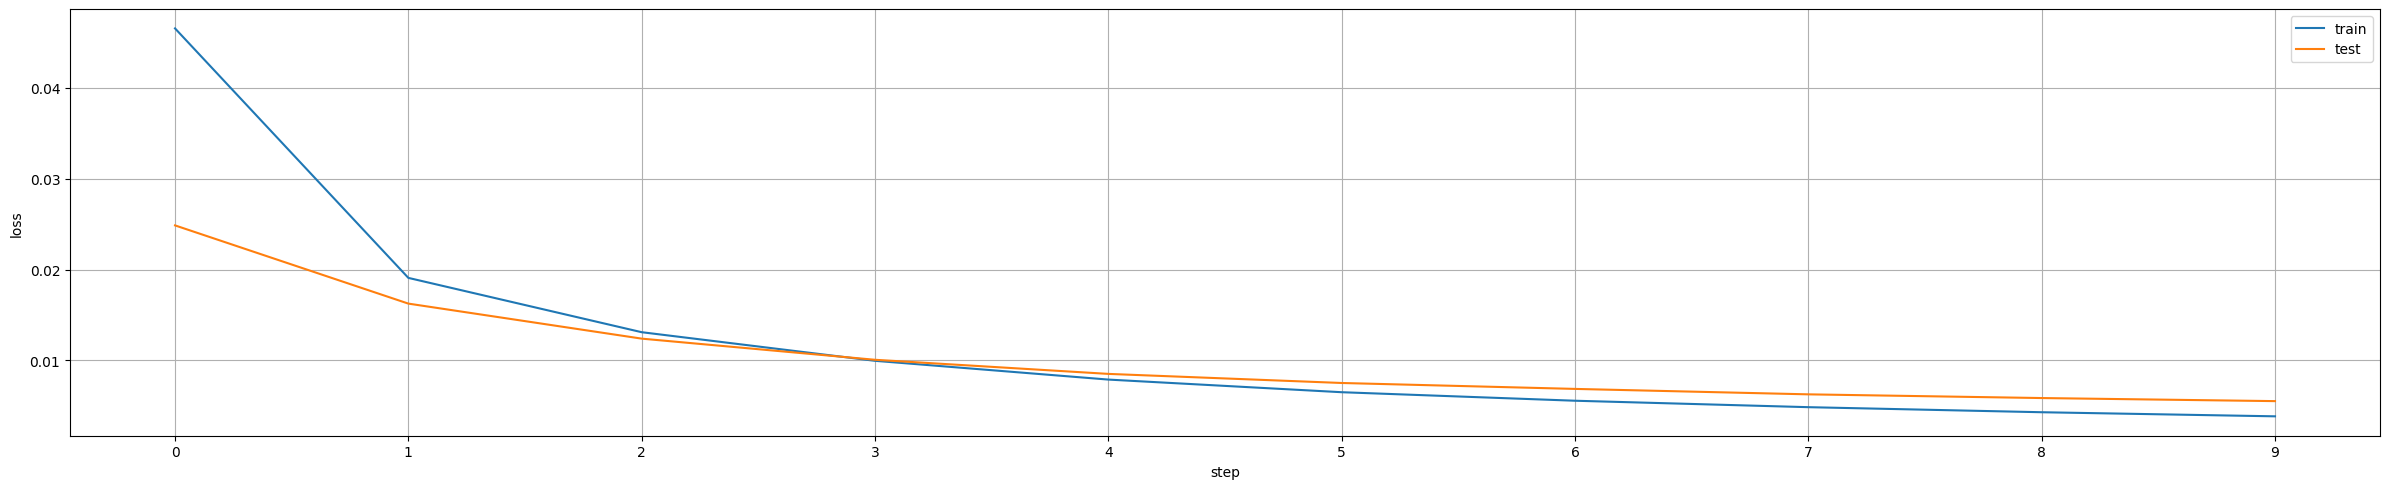

CPU times: total: 4min 7s
Wall time: 18 s


In [15]:
%%time

most_important = np.argsort(variance)[-500:]

model = Net(500).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp500 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [16]:
loss_500 = pp500.history_dict["loss"]["test"][-1]
print(f"Loss 500: {loss_500}")

Loss 500: 0.005512530275154859


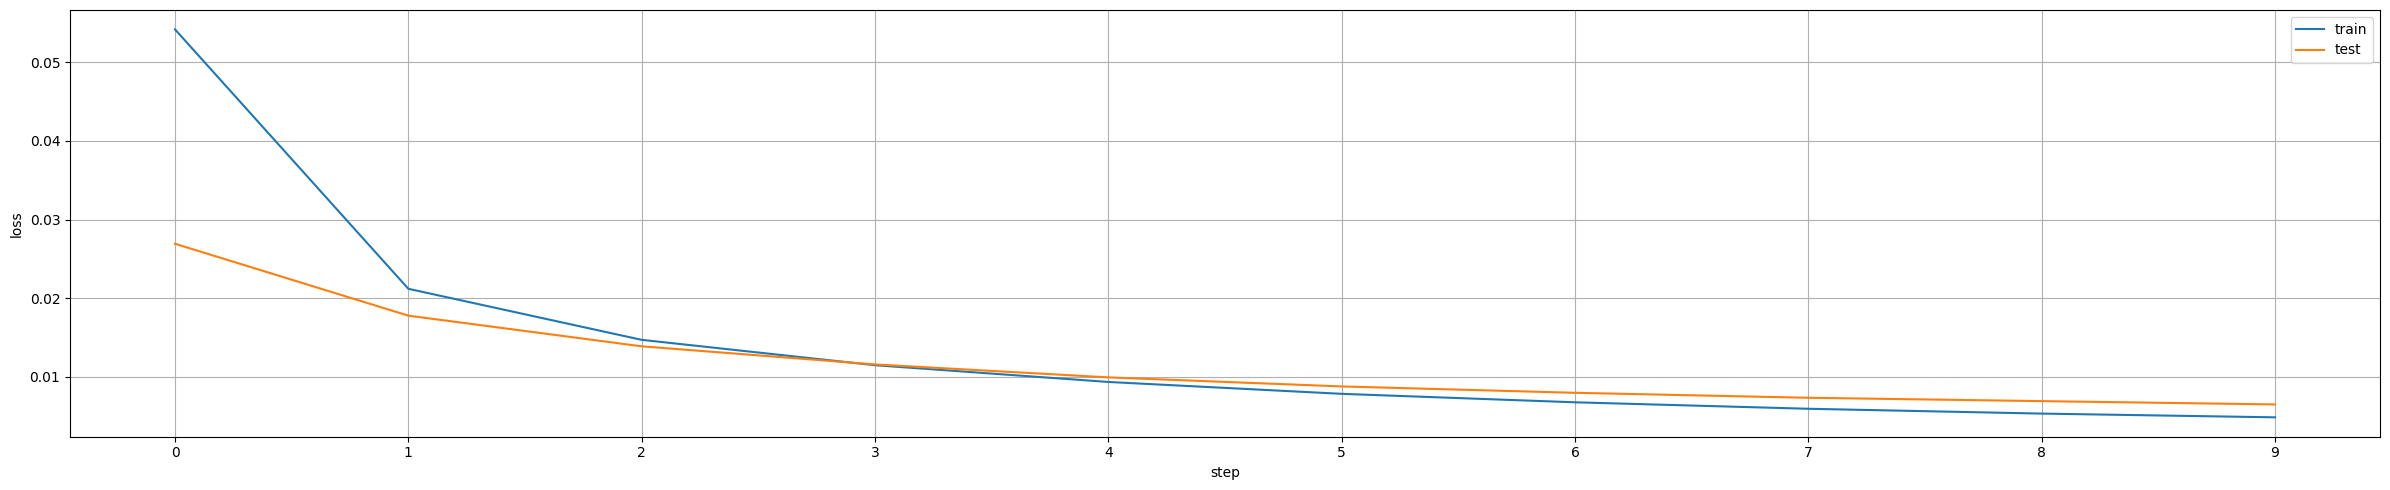

CPU times: total: 4min 6s
Wall time: 17.9 s


In [17]:
%%time

most_important = np.argsort(variance)[-200:]

model = Net(200).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp200 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [18]:
loss_200 = pp200.history_dict["loss"]["test"][-1]
print(f"Loss 200: {loss_200}")

Loss 200: 0.006508516380563378


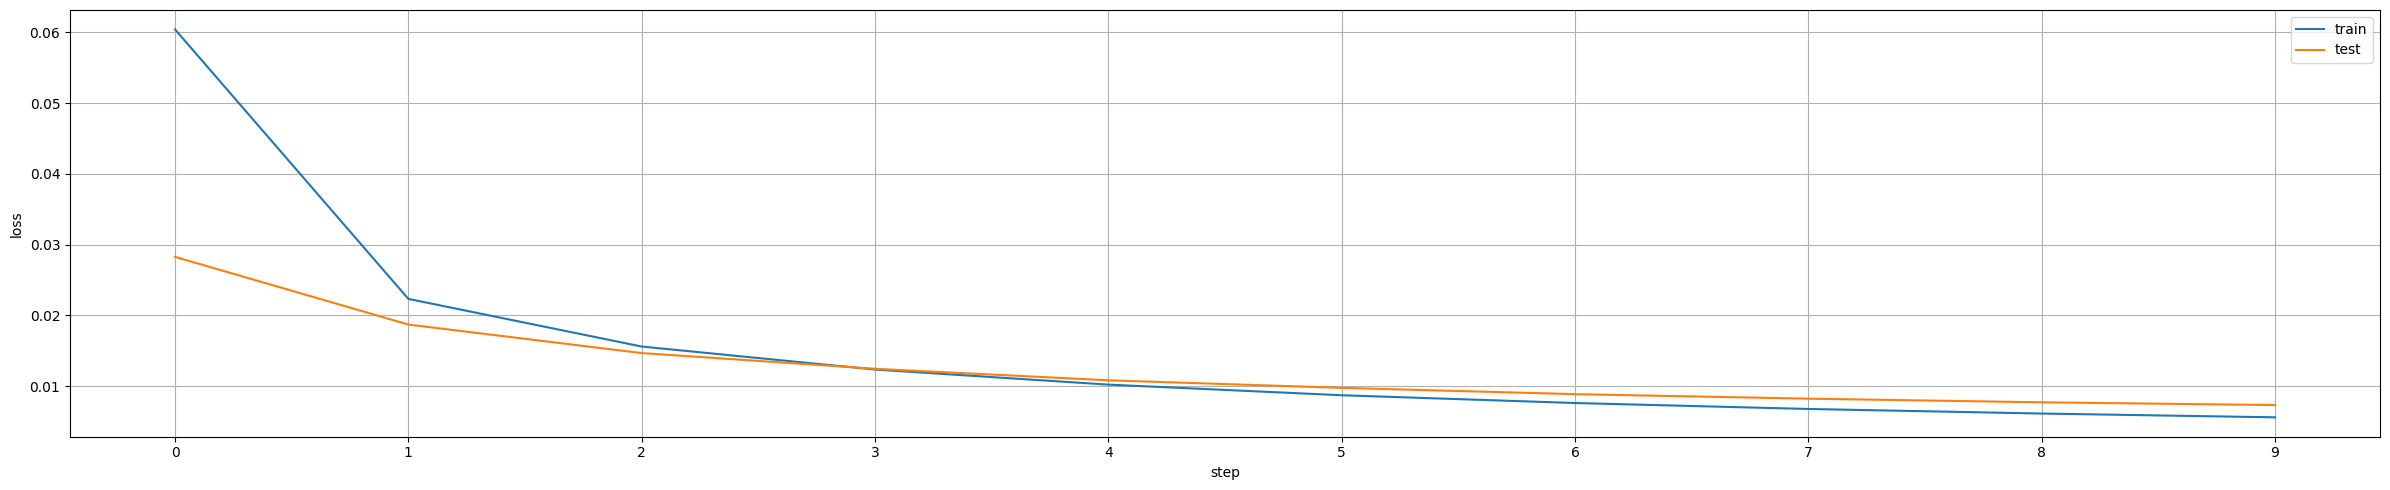

CPU times: total: 4min 1s
Wall time: 18 s


In [19]:
%%time

most_important = np.argsort(variance)[-100:]

model = Net(100).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp100 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [20]:
loss_100 = pp100.history_dict["loss"]["test"][-1]
print(f"Loss 100: {loss_100}")

Loss 100: 0.007315382419619709


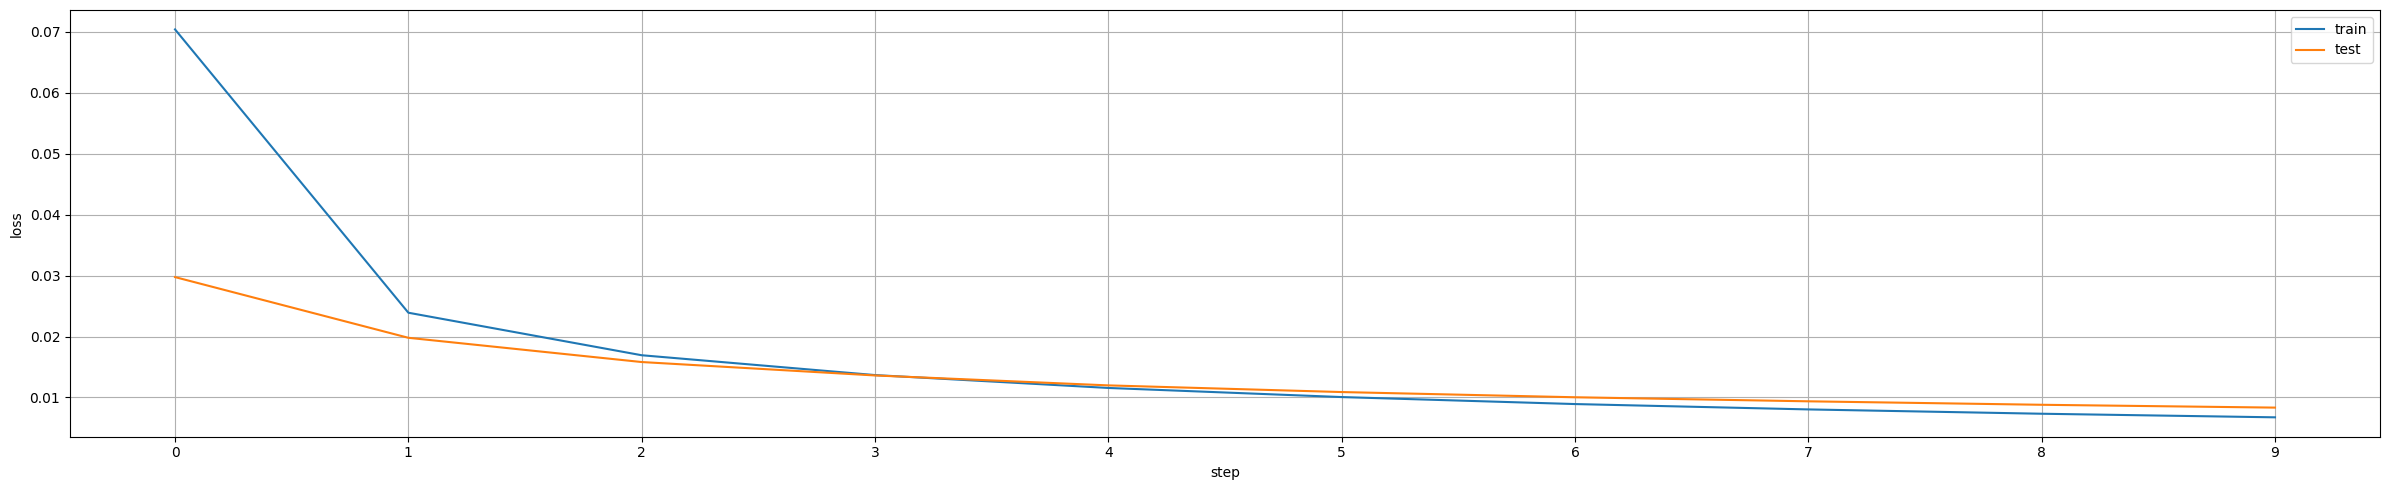

CPU times: total: 4min 8s
Wall time: 18.1 s


In [21]:
%%time

most_important_64 = np.argsort(variance)[-64:]

model_64 = Net(64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_64.parameters(), lr=0.0001)

pp64 = train(model_64, criterion, optimizer, most_important_64, train_loader, test_loader)

In [22]:
loss_64 = pp64.history_dict["loss"]["test"][-1]
print(f"Loss 64: {loss_64}")

Loss 64: 0.008335234015248716


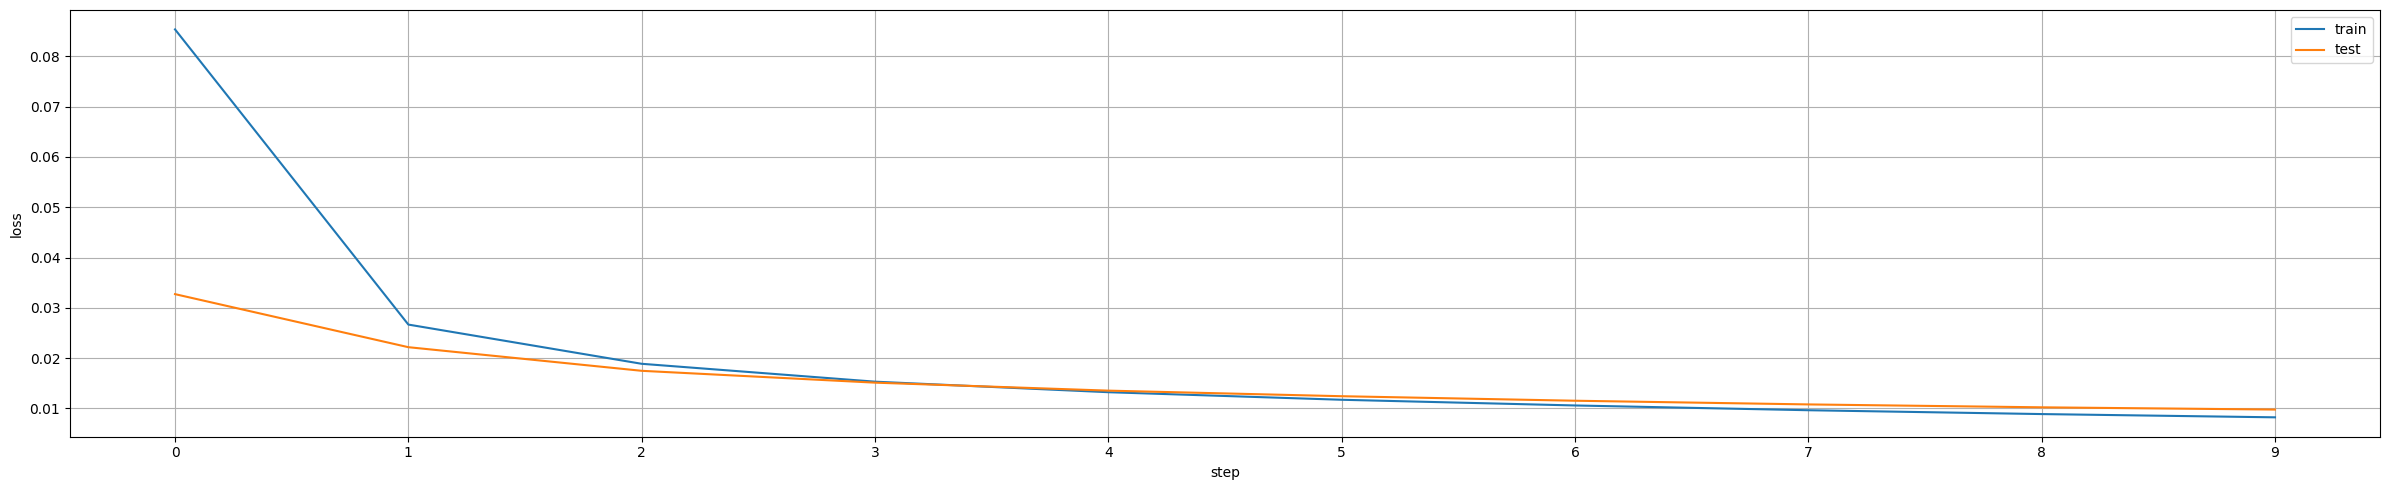

CPU times: total: 4min 3s
Wall time: 17.9 s


In [23]:
%%time

most_important = np.argsort(variance)[-40:]

model = Net(40).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp40 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [24]:
loss_40 = pp40.history_dict["loss"]["test"][-1]
print(f"Loss 40: {loss_40}")

Loss 40: 0.00978309684433043


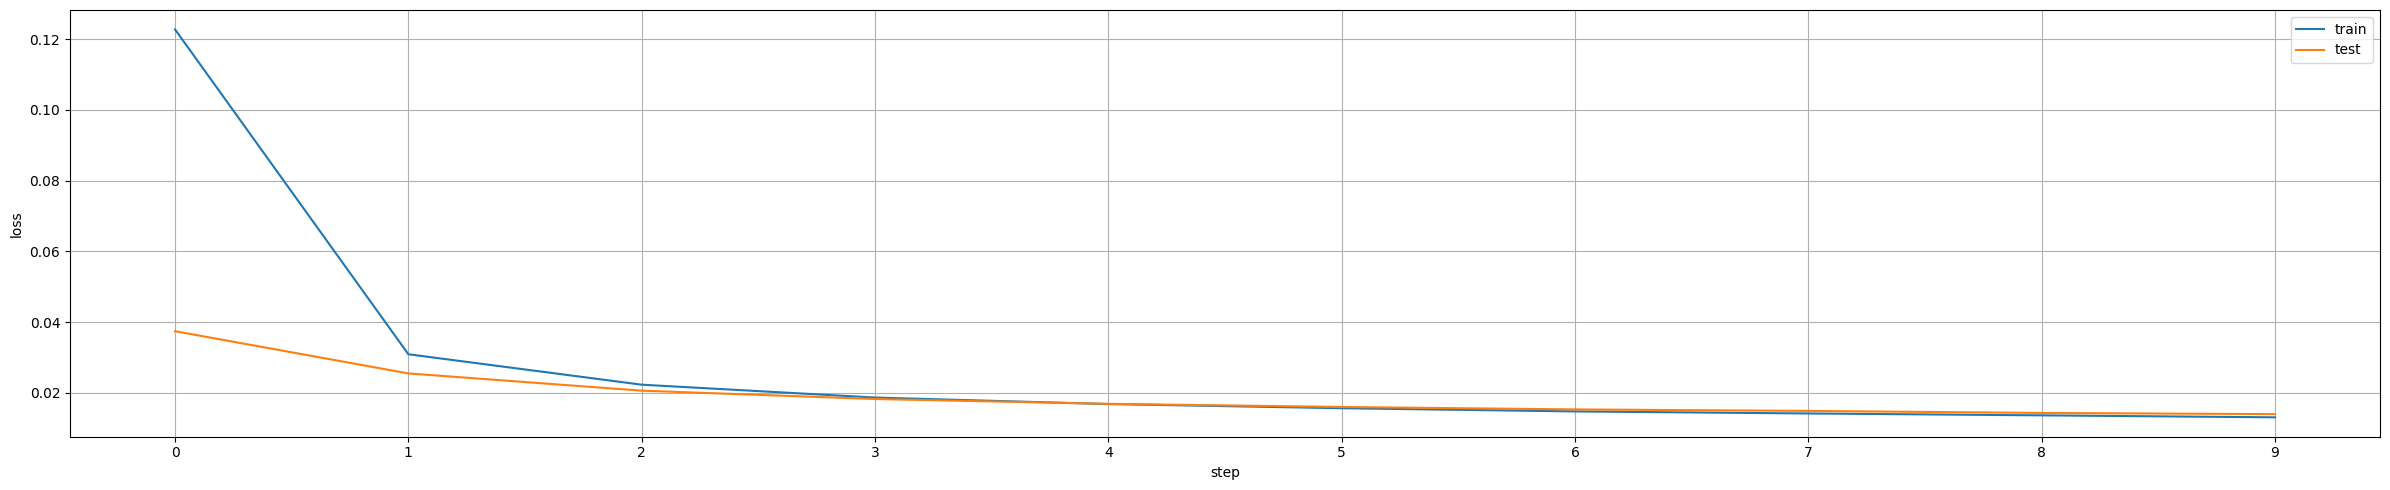

CPU times: total: 4min 4s
Wall time: 17.8 s


In [25]:
%%time

most_important = np.argsort(variance)[-20:]

model = Net(20).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp20 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [26]:
loss_20 = pp20.history_dict["loss"]["test"][-1]
print(f"Loss 20: {loss_20}")

Loss 20: 0.013960032840259373


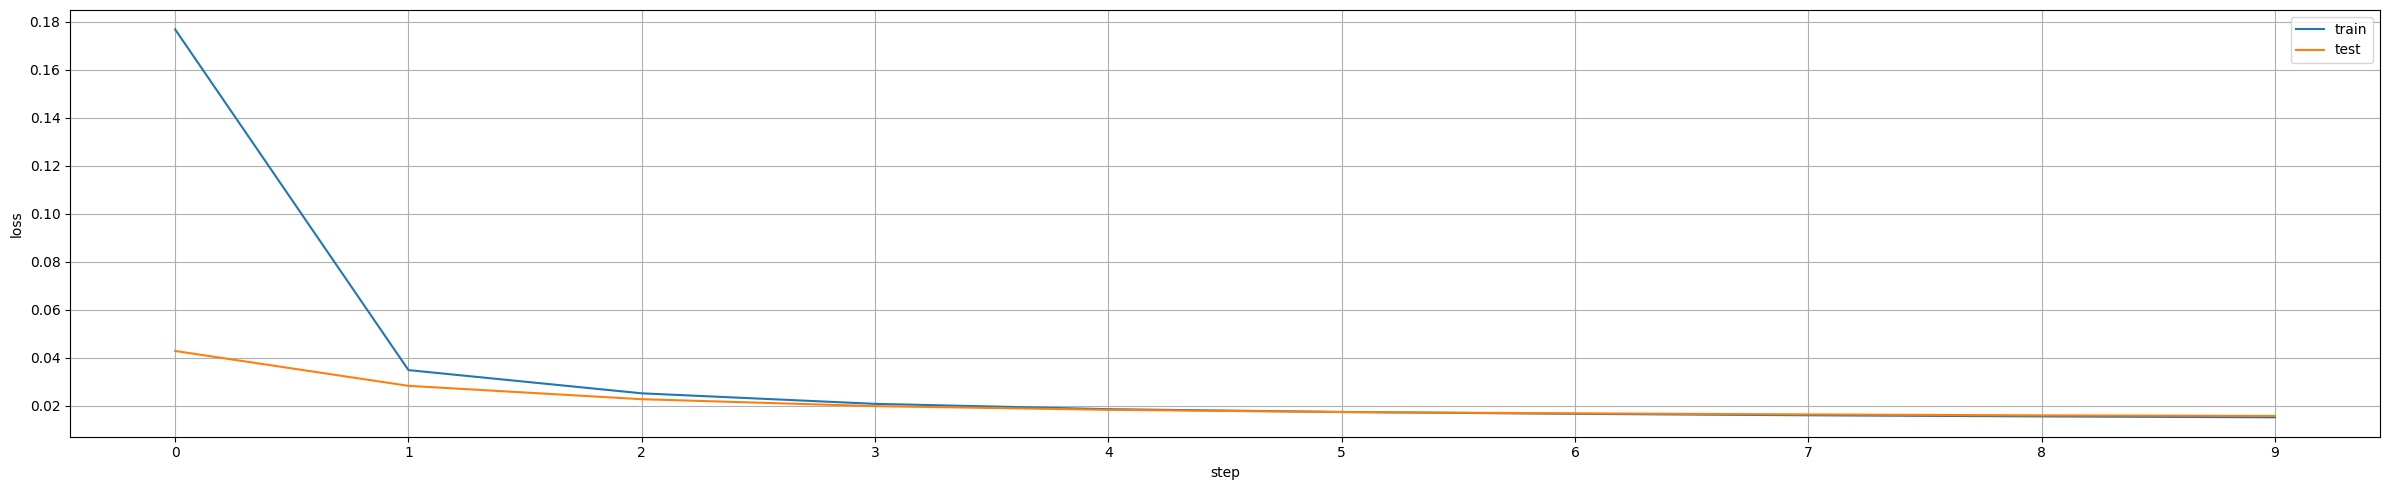

CPU times: total: 4min 6s
Wall time: 18.1 s


In [27]:
%%time

most_important = np.argsort(variance)[-10:]

model = Net(10).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp10 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [28]:
loss_10 = pp10.history_dict["loss"]["test"][-1]
print(f"Loss 10: {loss_10}")

Loss 10: 0.015672472305595875


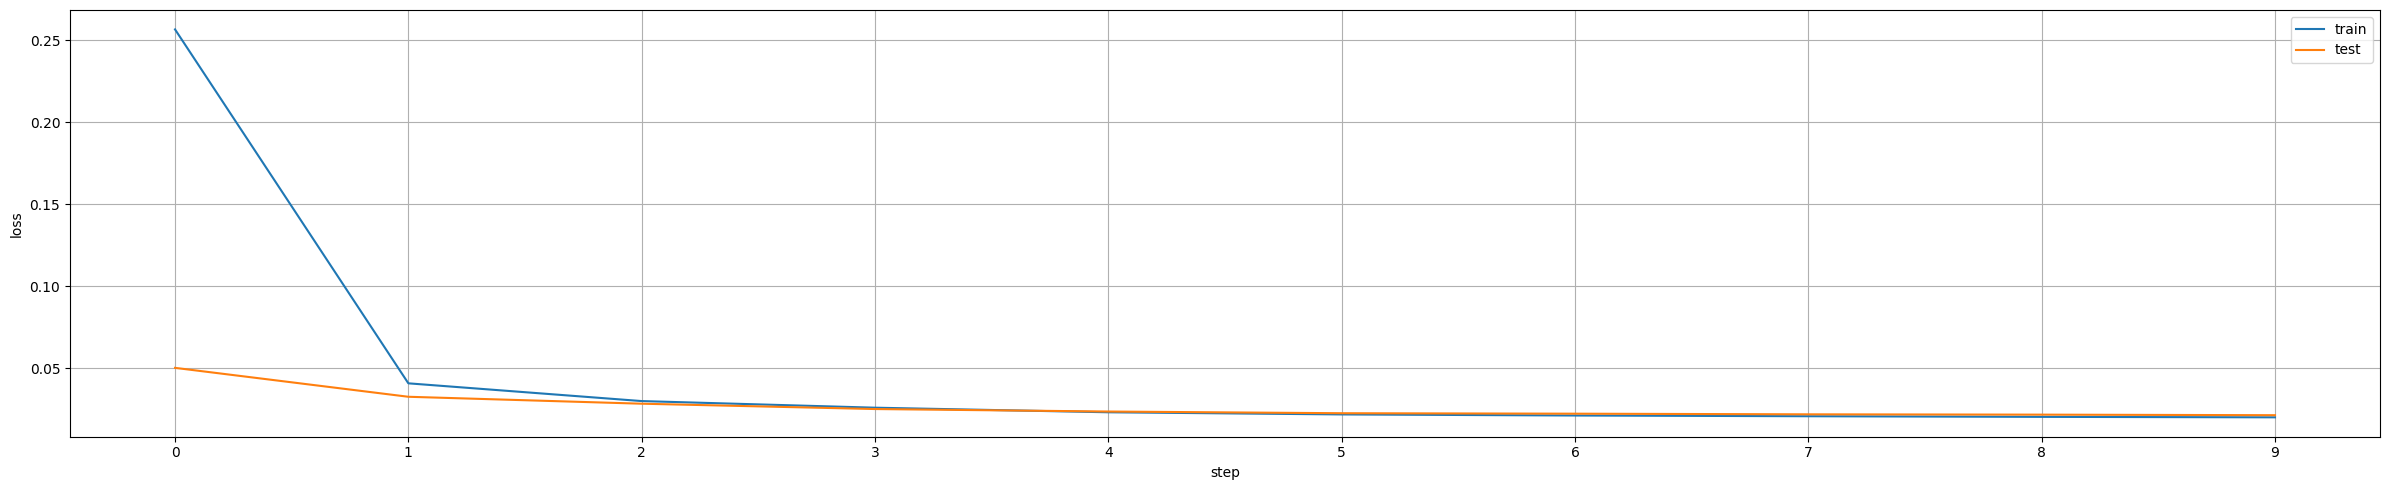

CPU times: total: 4min 11s
Wall time: 19.1 s


In [29]:
%%time

most_important = np.argsort(variance)[-5:]

model = Net(5).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp5 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [30]:
loss_5 = pp5.history_dict["loss"]["test"][-1]
print(f"Loss 5: {loss_5}")

Loss 5: 0.021317920880392194


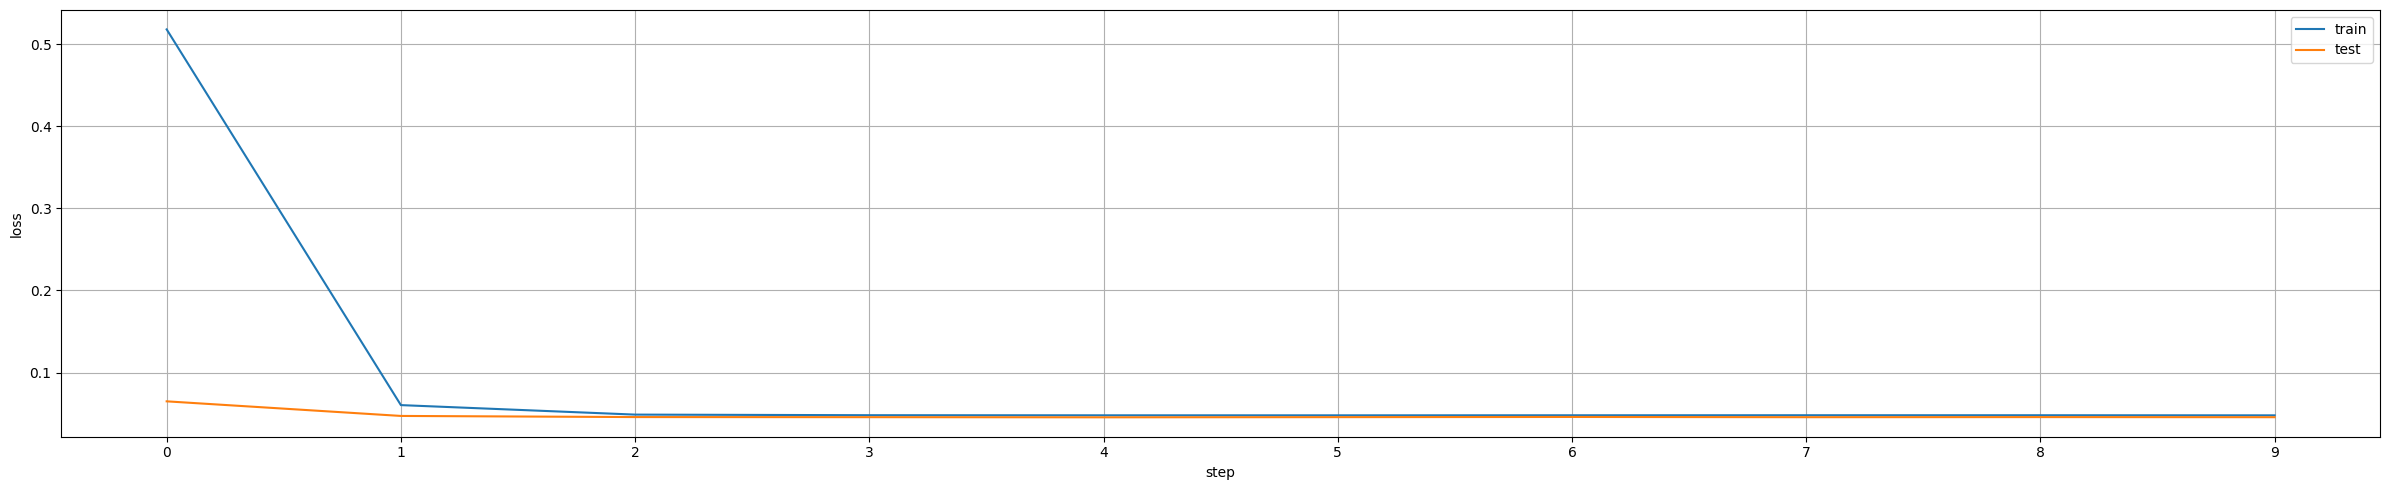

CPU times: total: 4min 11s
Wall time: 18.9 s


In [31]:
%%time

most_important_1 = np.argsort(variance)[-1:]

model_1 = Net(1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)

pp1 = train(model_1, criterion, optimizer, most_important_1, train_loader, test_loader)

In [32]:
loss_1 = pp1.history_dict["loss"]["test"][-1]
print(f"Loss 1: {loss_1}")

Loss 1: 0.04565062839537859


# Images and metrics

In [33]:
def get_predictions(measurements, model, most_important, option):
    
    if option == "full":

        x = measurements[:, most_important]
        pred = model(x).to(device)
        pred = torch.reshape(pred, (batch_size, px, px))

        return x, pred
    
    elif option == "short-cut":
        measurements_0, measurements_1 = measurements

        x_0 = measurements_0[:, most_important]
        x_1 = measurements_1[:, most_important]

        for i in range(batch_size):
            pred_0 = torch.reshape(model(x_0).to(device), (batch_size, px, px))
            pred_1 = torch.reshape(model(x_1).to(device), (batch_size, px, px))

        return (x_0, x_1), (pred_0, pred_1)

In [34]:
if option == "full":
    measurements, target_imgs = next(iter(test_loader))
    measurements, target_imgs = measurements.to(device), target_imgs.to(device)

    x_1024, pred_1024 = get_predictions(measurements, model_1024, most_important_1024, option)
    x_64, pred_64 = get_predictions(measurements, model_64, most_important_64, option)
    x_1, pred_1 = get_predictions(measurements, model_1, most_important_1, option)

    target_imgs = torch.reshape(target_imgs, (batch_size, px, px))

elif option == "short-cut":
    measurements_0, target_imgs_0 = next(iter(test_loader))
    measurements_0, target_imgs_0 = measurements_0.to(device), target_imgs_0.to(device)

    for batch in test_loader:
        measurements_1, target_imgs_1 = batch
        measurements_1, target_imgs_1 = measurements_1.to(device), target_imgs_1.to(device)
    
    measurements = (measurements_0, measurements_1)
    target_imgs = (target_imgs_0, target_imgs_1)

    x_1024, pred_1024 = get_predictions(measurements, model_1024, most_important_1024, option)
    x_64, pred_64 = get_predictions(measurements, model_64, most_important_64, option)
    x_1, pred_1 = get_predictions(measurements, model_1, most_important_1, option)

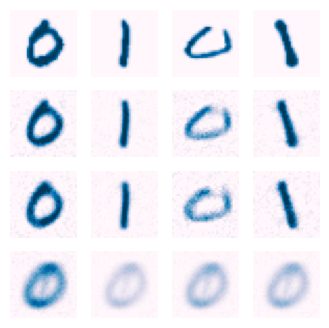

In [35]:
if option == "full":
    fig, axs = plt.subplots(4, 10, figsize=(12, 4))

    vmin = 0
    vmax = 1

    for i in range(10):
        target_image = target_imgs[i].cpu().numpy()
        predicted_image_1024 = pred_1024[i].detach().cpu().numpy()
        predicted_image_64 = pred_64[i].detach().cpu().numpy()
        predicted_image_1 = pred_1[i].detach().cpu().numpy()

        img = axs[0,i].imshow(target_image, vmin=vmin, vmax=vmax, cmap="PuBu")
        img = axs[1,i].imshow(predicted_image_1024, vmin=vmin, vmax=vmax, cmap="PuBu")
        img = axs[2,i].imshow(predicted_image_64, vmin=vmin, vmax=vmax, cmap="PuBu")
        img = axs[3,i].imshow(predicted_image_1, vmin=vmin, vmax=vmax, cmap="PuBu")

        for j in range(4):
            axs[j,i].set_axis_off()

    # fig.colorbar(img, ax=axs[:,:])

elif option == "short-cut":
    fig, axs = plt.subplots(4, 4, figsize=(4, 4))

    targets = [target_imgs[0][0], target_imgs[1][0], target_imgs[0][40], target_imgs[1][61]]
    predictions_1024 = [pred_1024[0][0], pred_1024[1][0], pred_1024[0][40], pred_1024[1][61]]
    predictions_64 = [pred_64[0][0], pred_64[1][0], pred_64[0][40], pred_64[1][61]]
    predictions_1 = [pred_1[0][0], pred_1[1][0], pred_1[0][40], pred_1[1][61]]

    vmin = 0
    vmax = 1

    for i in range(4):

        target_image = targets[i].reshape(px, px).cpu().numpy()
        predicted_image_1024 = predictions_1024[i].detach().cpu().reshape(px, px)
        predicted_image_64 = predictions_64[i].detach().cpu().reshape(px, px)
        predicted_image_1 = predictions_1[i].detach().cpu().reshape(px, px)

        axs[0,i].set_axis_off()
        axs[1,i].set_axis_off()
        axs[2,i].set_axis_off()
        axs[3,i].set_axis_off()

        img = axs[0,i].imshow(target_image, vmin=vmin, vmax=vmax, cmap="PuBu")
        img = axs[1,i].imshow(predicted_image_1024, vmin=vmin, vmax=vmax, cmap="PuBu")
        img = axs[2,i].imshow(predicted_image_64, vmin=vmin, vmax=vmax, cmap="PuBu")
        img = axs[3,i].imshow(predicted_image_1, vmin=vmin, vmax=vmax, cmap="PuBu")

    # fig.colorbar(img, ax=axs[:,:])

In [36]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

def ssim_calculate(pred, target_imgs, option):
    
    if option == "full":
        ssim = StructuralSimilarityIndexMeasure().to(device)
        target_imgs = torch.reshape(target_imgs, (batch_size, 1, px, px))
        pred = torch.reshape(pred, (batch_size, 1, px, px))
        s = ssim(pred, target_imgs)
        print(s)

    elif option == "short-cut":
        s = 0
        ssim = StructuralSimilarityIndexMeasure().to(device)

        target_imgs_0 = target_imgs[0].reshape(batch_size, 1, px, px)
        target_imgs_1 = target_imgs[1].reshape(batch_size, 1, px, px)

        pred_0 = pred[0].reshape(batch_size, 1, px, px)
        pred_1 = pred[1].reshape(batch_size, 1, px, px)

        s += ssim(pred_0, target_imgs_0)
        s += ssim(pred_1, target_imgs_1)
        s /= 2
    
    return s

In [37]:
ssim_1024 = ssim_calculate(pred_1024, target_imgs, option)
print("SSIM 1024", ssim_1024.item())

SSIM 1024 0.8084967732429504


In [38]:
ssim_64 = ssim_calculate(pred_64, target_imgs, option)
print("SSIM 64", ssim_64.item())

SSIM 64 0.7618513107299805


In [39]:
ssim_1 = ssim_calculate(pred_1, target_imgs, option)
print("SSIM 1", ssim_1.item())

SSIM 1 0.17460057139396667


In [40]:
print(pp64.history_dict["loss"]["train"])

[0.070396513864398, 0.023905420675873756, 0.01692830412648618, 0.013674678094685078, 0.01156098241917789, 0.010066104028373957, 0.008918267884291708, 0.008038196945562959, 0.007329723052680493, 0.006740917591378093]


In [41]:
print(pp64.history_dict["loss"]["test"])

[0.029752071015536785, 0.019791377941146493, 0.015812940197065473, 0.013611450442112982, 0.011981726856902242, 0.01088796416297555, 0.010033098864369094, 0.009367976570501924, 0.008799618226476014, 0.008335234015248716]
